In [ ]:
import pandas as pd
import os
from Bio import SeqIO

def mutate(wt_seq, mut_str):
    muts = mut_str.split(':')
    mut_aa = [muts_[-1] for muts_ in muts]
    mut_pos = [int(muts_[1:-1]) for muts_ in muts]
    orgin_aa = [muts_[0] for muts_ in muts]
    wt_seq = list(wt_seq)
    for i in range(len(mut_aa)):
        assert wt_seq[mut_pos[i]] == orgin_aa[i]
        wt_seq[mut_pos[i]] = mut_aa[i]
        
    return ''.join(wt_seq)

def gen_mut_str(mut_seq, wt_seq, mut_pos=[60, 63, 79]):
    mut_str = [f'{wt_seq[i]}{i}{mut_seq[i]}' for i in mut_pos]
    # for i in range(len(mut_seq)):
    #     if mut_seq[i] != wt_seq[i]:
    #         mut_str.append(f'{wt_seq[i]}{i}{mut_seq[i]}')
    return ':'.join(mut_str)

raw_data_dir = '../data/ParD3/coevolution_mechanism/data/1raw_read_output/at_combo_lib'
wt_record = SeqIO.parse('../data/ParD3/wt_seq.fasta', 'fasta')
wt_seq = str(next(wt_record).seq)
print(f'wt_seq: {wt_seq[60]}, {wt_seq[63]}, {wt_seq[79]}, {len(wt_seq)}')
results = {}
labels = []
for root, dirs, files in os.walk(raw_data_dir):
    for file in files:
        if file.endswith('.csv'):
            toxin = 'fit_' + file.split('.')[0][3:]
            labels.append(toxin)
            df = pd.read_csv(os.path.join(root, file))
            # print(file, len(df))
            df = df[(df['stop'] == False) & (df['full_mut'] != 'wtAT')]
            print(file, len(df), len(set(df['full_mut'].tolist())))
            mutants = df['full_mut'].tolist()
            for mut in mutants:
                assert '_' not in mut, mut
            mut_seqs = [mutate(wt_seq, mut) for mut in mutants]
            fitness = df['mean_fit'].tolist()
            for i, seq in enumerate(mut_seqs):
                assert len(seq) == len(wt_seq)
                if seq not in results:
                    results[seq] = {}
                results[seq][toxin] = fitness[i]
print(len(results), len(set(results.keys())))
mut_sequences = list(results.keys())
df_dict = {'sequence': mut_sequences, 'mut_str': [gen_mut_str(mut_seq, wt_seq) for mut_seq in mut_sequences]}
for toxin in labels:
    df_dict[toxin] = [results[mut_seq][toxin] for mut_seq in mut_sequences]
save_df = pd.DataFrame(df_dict)
save_df.to_csv('../data/ParD3/ground_truth_ParD3_raw.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/ParD3/ground_truth_ParD3_raw.csv')
fit_cols = [col for col in df.columns if col.startswith('fit_')]
df_fit = df[fit_cols]
corr = df_fit.corr()
# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Correlation Heatmap for Columns Starting with "fit"')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/ParD3/ground_truth_ParD3_normalized.csv')
fit_cols = [col for col in df.columns if col.startswith('fit_')]
df_fit = df[fit_cols]
corr = df_fit.corr()
# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Correlation Heatmap for Columns Starting with "fit"')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
results = {}
labels = []
for root, dirs, files in os.walk(raw_data_dir):
    for file in files:
        if file.endswith('.csv'):
            toxin = 'fit_' + file.split('.')[0][3:]
            labels.append(toxin)
            df = pd.read_csv(os.path.join(root, file))
            # print(file, len(df))
            non_stop_df = df[(df['stop'] == False) & (df['full_mut'] != 'wtAT')]
            print(file, len(non_stop_df), len(set(non_stop_df['full_mut'].tolist())))
            mutants = non_stop_df['full_mut'].tolist()
            for mut in mutants:
                assert '_' not in mut, mut
            mut_seqs = [mutate(wt_seq, mut) for mut in mutants]
            fitness = non_stop_df['mean_fit'].values
            if toxin == 'fit_E2':
                max_fit = non_stop_df[non_stop_df['full_mut'] == 'D60I:K63L:E79K']['mean_fit'].values[0]
            else:
                max_fit = non_stop_df[non_stop_df['full_mut'] == 'D60D:K63K:E79E']['mean_fit'].values[0]
            min_fit = df[df['stop'] == True]['mean_fit'].values.mean()
            fitness = (fitness - min_fit) / (max_fit - min_fit)
            for i, seq in enumerate(mut_seqs):
                assert len(seq) == len(wt_seq)
                if seq not in results:
                    results[seq] = {}
                results[seq][toxin] = fitness[i]
print(len(results), len(set(results.keys())))
mut_sequences = list(results.keys())
df_dict = {'sequence': mut_sequences, 'mut_str': [gen_mut_str(mut_seq, wt_seq) for mut_seq in mut_sequences]}
for toxin in labels:
    df_dict[toxin] = [results[mut_seq][toxin] for mut_seq in mut_sequences]
save_df = pd.DataFrame(df_dict)
save_df.to_csv('../data/ParD3/ground_truth_ParD3_normalized.csv', index=False)

In [ ]:
df_kerr = pd.read_csv('/work/kerr/p450/mutation/results/ParD3/df_gt.csv')
df_kerr = df_kerr[~df_kerr['full_mut'].str.contains('_')]
df_norm = pd.read_csv('../data/ParD3/ground_truth_ParD3_normalized.csv')
print(len(df_kerr), len(df_norm))
print(set(df_kerr['full_mut'].tolist()) - set(df_norm['mut_str'].tolist()))
# len(set(df_kerr['full_mut'].tolist()) - set(df_norm['mut_str'].tolist()))
len(set(df_norm['mut_str'].tolist())), len(set(df_kerr['full_mut'].tolist()))
df_kerr['full_mut'].tolist() == df_norm['mut_str'].tolist()

toxins = []
for root, dirs, files in os.walk(raw_data_dir):
    for file in files:
        if file.endswith('.csv'):
            toxins.append(file.split('.')[0][3:])
print(len(toxins))
import numpy as np
for toxin in toxins:
    fit_kerr = df_kerr['Fitness_' + toxin].values
    fit_norm = df_norm['fit_' + toxin].values
    print(toxin, np.corrcoef(fit_kerr, fit_norm)[0, 1], np.max(np.abs(fit_kerr - fit_norm)))

In [ ]:
import pandas as pd

df = pd.read_csv('../data/ParD3/ground_truth_ParD3_normalized.csv')
filtered_df = df[['sequence', 'fit_E3', 'fit_E2']]
filtered_df.to_csv('../data/ParD3/ground_truth_ParD3_E3_E2.csv', index=False)

In [17]:
import pandas as pd

percentile_low, percentile_high = 0.1, 0.4
df = pd.read_csv('../data/ParD3/ground_truth_ParD3_E3_E2.csv')
print(df[df['sequence'] == 'MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWKEGYASGRPEPVDFDALRKVARQKLTEVPPNGR'])
input()
scores_E3 = df['fit_E3'].tolist()
scores_E2 = df['fit_E2'].tolist()
scores_E2.sort()
scores_E3.sort()
score_E2_99percentile = scores_E2[int(len(scores_E2) * 0.99)]
score_E3_99percentile = scores_E3[int(len(scores_E3) * 0.99)]
print(f'scores_E2_99percentile: {score_E2_99percentile}, scores_E3_99percentile: {score_E3_99percentile}')
score_E2_low = score_E2_99percentile * percentile_low
score_E2_high = score_E2_99percentile * percentile_high
score_E3_low = score_E3_99percentile * percentile_low
score_E3_high = score_E3_99percentile * percentile_high
print(f'score_E2_low: {score_E2_low}, score_E2_high: {score_E2_high}')
print(f'score_E3_low: {score_E3_low}, score_E3_high: {score_E3_high}')
print(2, df[df['sequence'] == 'MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWKEGYASGRPEPVDFDALRKVARQKLTEVPPNGR'])
input()
# print((df['fit_E2'] >= score_E2_low) & (df['fit_E2'] <= score_E2_high) & (df['fit_E3'] >= score_E3_low) & (df['fit_E3'] <= score_E3_high))
# filter_df = df[(df['fit_E2'] >= score_E2_low) & (df['fit_E2'] <= score_E2_high) & (df['fit_E3'] >= score_E3_low) & (df['fit_E3'] <= score_E3_high)].copy()
# filter_df = filter_df.reset_index(drop=True)
# # filter_df = df[(df['fit_E2'] >= score_E2_low) & (df['fit_E2'] <= score_E2_high)]
# # print(len(df[(df['fit_E2'] >= score_E2_low) & (df['fit_E2'] <= score_E2_high)]), len(df[(df['fit_E3'] >= score_E3_low) & (df['fit_E3'] <= score_E3_high)]))
# # print(len(df[(df['fit_E2'] >= score_E2_low) & (df['fit_E2'] <= score_E2_high) & (df['fit_E3'] >= score_E3_low) & (df['fit_E3'] <= score_E3_high)]))
# print('filter_df:', len(filter_df))
# print(filter_df)
# print(len(filter_df))
# print(filter_df['sequence'].tolist()[0])
# filter_df.to_csv(f'../data/ParD3/E2_E3_percentile_{percentile_low}_{percentile_high}.csv', index=False)
seqs = df['sequence'].tolist()
fit_E3 = df['fit_E3'].tolist()
fit_E2 = df['fit_E2'].tolist()
print(df[df['sequence'] == 'MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWKEGYASGRPEPVDFDALRKVARQKLTEVPPNGR'])
filtered_seqs, filtered_fit_E3, filtered_fit_E2 = [], [], []
for i in range(len(seqs)):
    if fit_E3[i] >= score_E3_low and fit_E3[i] <= score_E3_high and fit_E2[i] >= score_E2_low and fit_E2[i] <= score_E2_high:
        if seqs[i] == 'MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWKEGYASGRPEPVDFDALRKVARQKLTEVPPNGR':
            print(fit_E3[i], fit_E2[i])
            input()
        filtered_seqs.append(seqs[i])
        filtered_fit_E3.append(fit_E3[i])
        filtered_fit_E2.append(fit_E2[i])
print(len(filtered_seqs))
filtered_df = pd.DataFrame({'sequence': filtered_seqs, 'fit_E3': filtered_fit_E3, 'fit_E2': filtered_fit_E2})
filtered_df.to_csv(f'../data/ParD3/E2_E3_percentile_{percentile_low}_{percentile_high}.csv', index=False)

                                               sequence    fit_E3    fit_E2
3597  MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...  0.379471  0.062469


scores_E2_99percentile: 0.9661204216410992, scores_E3_99percentile: 0.9472715055277472
score_E2_low: 0.09661204216410993, score_E2_high: 0.3864481686564397
score_E3_low: 0.09472715055277472, score_E3_high: 0.3789086022110989
2                                                sequence    fit_E3    fit_E2
3597  MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...  0.379471  0.062469
                                               sequence    fit_E3    fit_E2
3597  MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...  0.379471  0.062469
1321


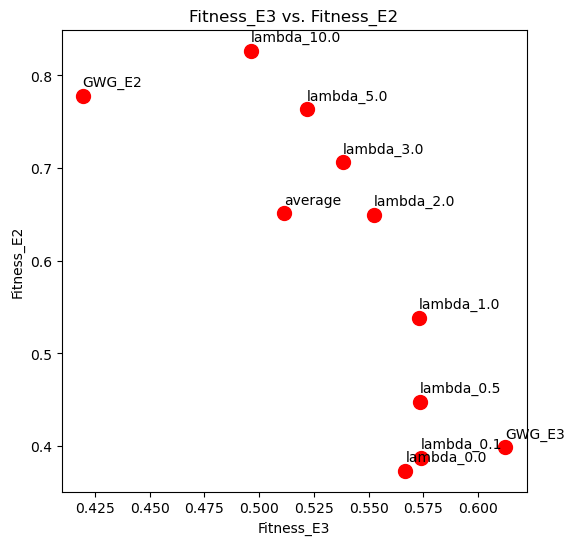

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def load_metric_point_label(csv_path, label):
    df = pd.read_csv(csv_path)
    metrics = df['mean'].values[:2]
    x = metrics[0]
    y = metrics[1]
    
    return x, y, label

E3_E2_labels = []
csv_path_label = [[]]
for csv_path, label in csv_path_label:
    E3_E2_labels.append(load_metric_point_label(csv_path, label))
# E3_E2_labels.append(load_metric_point_label('../logs_new/GWG_2_E3_E2_2023_10_07__22_51_34_debug/samples_20231007-225134/evaluation_metrics.csv', 'lambda_1.0'))
# E3_E2_labels.append(load_metric_point_label('../logs_new/GWG_2_E3_E2_2023_10_07__22_57_59_lambda2.0/samples_20231007-225759/evaluation_metrics.csv', 'lambda_2.0'))
# E3_E2_labels.append(load_metric_point_label('../logs_new/GWG_2_E3_E2_2023_10_07__23_00_12_lambda3.0/samples_20231007-230012/evaluation_metrics.csv', 'lambda_3.0'))
# E3_E2_labels.append(load_metric_point_label('../logs_new/GWG_2_E3_E2_2023_10_07__23_03_58_lambda5.0/samples_20231007-230358/evaluation_metrics.csv', 'lambda_5.0'))
# E3_E2_labels.append(load_metric_point_label('../logs_new/GWG_2_E3_E2_2023_10_07__23_05_51_lambda10.0/samples_20231007-230551/evaluation_metrics.csv', 'lambda_10.0'))
# E3_E2_labels.append(load_metric_point_label('../logs_new/GWG_2_E3_E2_2023_10_07__23_07_33_lambda0.5/samples_20231007-230733/evaluation_metrics.csv', 'lambda_0.5'))
# E3_E2_labels.append(load_metric_point_label('../logs_new/GWG_2_E3_E2_2023_10_07__23_10_57_lambda0.1/samples_20231007-231057/evaluation_metrics.csv', 'lambda_0.1'))
# E3_E2_labels.append(load_metric_point_label('../logs_new/GWG_2_E3_E2_2023_10_07__23_15_24_average/samples_20231007-231524/evaluation_metrics.csv', 'average'))
# E3_E2_labels.append(load_metric_point_label('../logs_new/train_predictor_E2_0.1_0.4_2023_10_07__22_43_47_augment/samples_20231007-224624/evaluation_metrics.csv', 'GWG_E2'))
# E3_E2_labels.append(load_metric_point_label('../logs_new/train_predictor_E3_0.1_0.4_2023_10_07__22_43_44_augment/samples_20231007-224622/evaluation_metrics.csv', 'GWG_E3'))
# E3_E2_labels.append(load_metric_point_label('../logs_new/GWG_2_E3_E2_2023_10_07__23_43_23_lambda0.0/samples_20231007-234323/evaluation_metrics.csv', 'lambda_0.0'))
E3, E2, labels = zip(*E3_E2_labels)

plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(E3, E2, c='r', marker='o', s=100)
for i in range(len(labels)):
    plt.annotate(labels[i], (E3[i], E2[i]), xytext=(E3[i], E2[i]+0.01))
plt.xlabel('Fitness_E3')
plt.ylabel('Fitness_E2')
plt.title('Fitness_E3 vs. Fitness_E2')
plt.show()
